In [2]:
import numpy as np
import scipy
import pandas as pd
import pybedtools as pb

# figs
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.dpi']= 150
import seaborn as sns


#import h5py
#import allel

# my libs
import EnrichRLib as erl
import RNA_expression_processing as rn
import Enh_Mut_Manip as emm

# warnings
import warnings
warnings.filterwarnings('ignore')
#warnings.simplefilter("ignore", ResourceWarning)

In [3]:
### == Math functions == 
def log2p1(x):
    return np.log2(x + 1)

In [4]:
# Project settings
from os.path import join 
WORKDIR = '/home/sergio/Res_CIML/TLX3_project'
SCRIPTS = join(WORKDIR,'scripts')
DATADIR = join(WORKDIR,'data')
WGS = join(DATADIR,'tracks/WGS-WES/Germline')
RP = join(DATADIR,'tracks/MARGE/relativeRP/bam_input')

# Data loading

### Genome Wide mutations in TLX3

In [5]:
## == Genome vcf
tlx_gn = pb.BedTool(join(WGS,'TLX3_WGS.vcf.gz'))

### RNA-expression table TLX3-vs-RAG

In [6]:
## == Expression table TLX3 vs RAG
tbl = pd.read_table(join(DATADIR,'tracks', 'TLX3vsRAG-results_genesNames.txt'), index_col=0)
#tbl = tbl[(tbl.padj < 0.05)].dropna()

# -- Pheno --
#A,B = 'TLX3','RAG'
#classes = [A]*3+[B]*3


cols = ['Gene_name', 'TLX3.1_1','TLX3.1_5','TLX3.1_P','R2.RAG1W.RAG1','RAGS.RAGZ','RAGZ']

tbn = tbl[cols]
expr = tbn.set_index(keys=tbn.columns[0])
#expr.index = expr.index.str.upper()

### Enhancers from chromatin states

In [7]:
## == Enhancers 
enh = pb.BedTool(join(DATADIR,'tracks/Enhancers_ChromHMM.bed'))
enh_df = enh.to_dataframe()

# Enh to genes table
enh2gn = pd.read_table(join(DATADIR,'tracks/Enhancers_ChromHMM_enh2genes.txt'), 
                        header=1, 
                        names=['enhancers','gene_name'])
# Gene to enh table
gn2enh = pd.read_table(join(DATADIR,'tracks/Enhancers_ChromHMM_genes2enh.txt'), 
                        header=1, 
                        names=['gene_name','enhancers'])


### Regulatory potentials based on H3K27ac -- TLX3-vs-RAG

In [8]:
# Regulatory Potentials
rpt  =  pd.read_table(join(RP,'RAG_TLX_TAP_relativeRP_mm10mm9.txt'))

# -- transform
rp = rpt.sort_values('lgFC_TLXvsRAG', axis=0, ascending=False)
rp.drop_duplicates(subset='gene_name', inplace=True)


Ap,Bp = 'TLX_rel_RP','RAG_rel_RP'
cols = ['gene_name', Ap, Bp]

rp = rp[cols]
rp = rp.set_index(keys=rp.columns[0])


### Annotations: genes, tss, T-all oncogenes etc.

In [9]:
# Load T-ALL ocnogenes
tall = erl.read_gmt(join(DATADIR,'gene_lists/Cancermine/T-ALL.gmt')) 
df_mut = pd.read_csv(join(DATADIR,'gene_lists/COSMIC/Genes_mutation_HUMAN_Acute-lymphoblastic-leukaemia.csv'))

df_mut['Gname'] = df_mut['Gene name'].apply(lambda x: x.split('_')[0])

tall_onc = tall['T-ALL all']
tall_mut = list(df_mut['Gname'].unique())

# Load genes body regions
genes = pb.BedTool(join(DATADIR,'tracks/annot_tracks/references/mm9/mm9.refGene.bed'))


# Story ONE: Active in TLX3 only enhancers and active genes 

![title](im/Story1.png)

## Active enhacers in TLX3 not in RAG based on H4K27ac potential

In [10]:
pad = 3e3 # 3k padding 

#tlx_27ac = join(DATADIR,'tracks/ChiP-seq_tracks/mm9_bigWig/TAP_H3K27ac_mm9.bw')
#rag_27ac = join(DATADIR,'tracks/ChiP-seq_tracks/mm9_bigWig/RAG_H3K27ac_mm9.bw')


#enh_27ac_tlx = emm.bigWig2bed_pot(tlx_27ac,enh,'mm9',pad=pad)

tlx_27ac = pd.read_csv(join(DATADIR,'tracks/Enhancers_ChromHMM_TLX3_H3K27ac.csv'), index_col=0)
rag_27ac = pd.read_csv(join(DATADIR,'tracks/Enhancers_ChromHMM_RAG_H3K27ac.csv'), index_col=0)

tlx_27ac.rename(columns={'RP':'RP_tlx'}, inplace=True)

rag_27ac.rename(columns={'RP':'RP_rag'}, inplace=True)

tlx_rag_27ac = pd.concat([tlx_27ac,rag_27ac.drop(['chrom','start','end', 'name'], axis=1)], axis=1)

In [11]:
# PolII in TLX3 signal on enhancers for verification
tlx_polII = pd.read_csv(join(DATADIR,'tracks/Enhancers_ChromHMM_TLX3_PolII.csv'), index_col=0)

tlx_polII.rename(columns={'RP':'RP_tlx_polII'}, inplace=True)
tlx_rag_27ac = pd.concat([tlx_27ac,rag_27ac.drop(['chrom','start','end', 'name'], axis=1)], axis=1)

tlx_rag_27ac_polII = pd.concat([tlx_27ac,
                                rag_27ac.drop(['chrom','start','end', 'name'], axis=1),
                                tlx_polII.drop(['chrom','start','end', 'name'], axis=1)], axis=1)

## Scatter plot of enhacer's activity TLX3-vs-RAG: color is PolII signal strength

(5.484464325834437, 14.766214510327096, 6.874249067576207, 14.182394229726976)

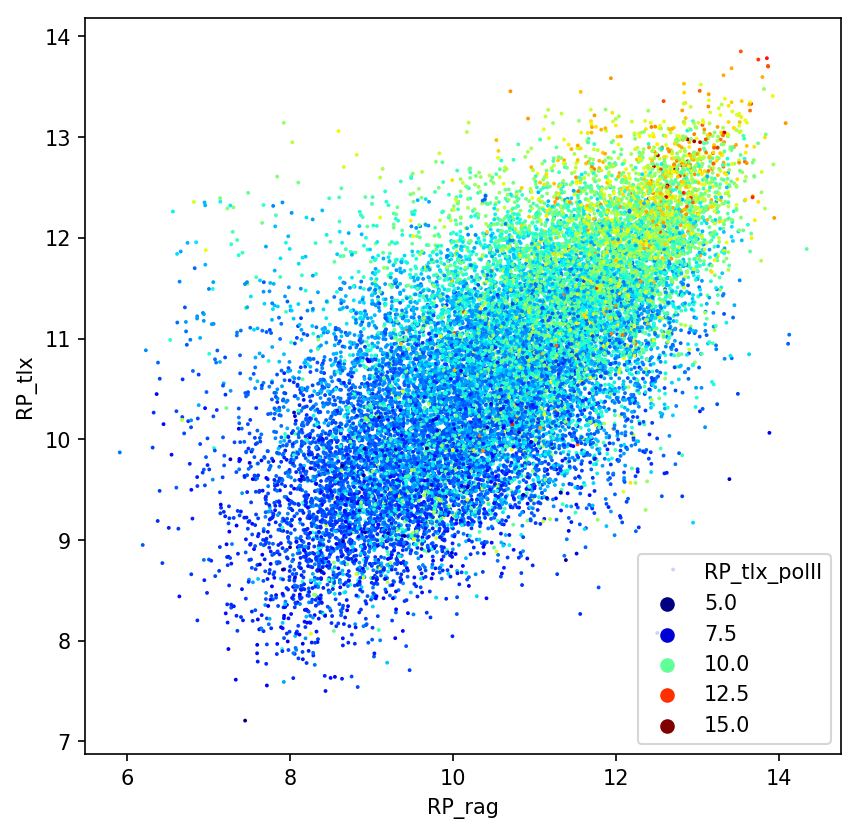

In [12]:
dpc = tlx_rag_27ac_polII.copy()#head(8000)

f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.scatterplot(x = log2p1(dpc['RP_rag']), 
                    y = log2p1(dpc['RP_tlx']), 
                    hue=log2p1(dpc['RP_tlx_polII']), 
                    data=dpc, 
                    ax=ax, 
                    palette='jet',#'gnuplot',#'jet',#'RdBu_r', 
                    linewidth=0, 
                    s=3.4)

ax.axis('equal')
ax.axis('tight')

## Scatter plot of enhacer's activity TLX3-vs-RAG: color logFoldChange

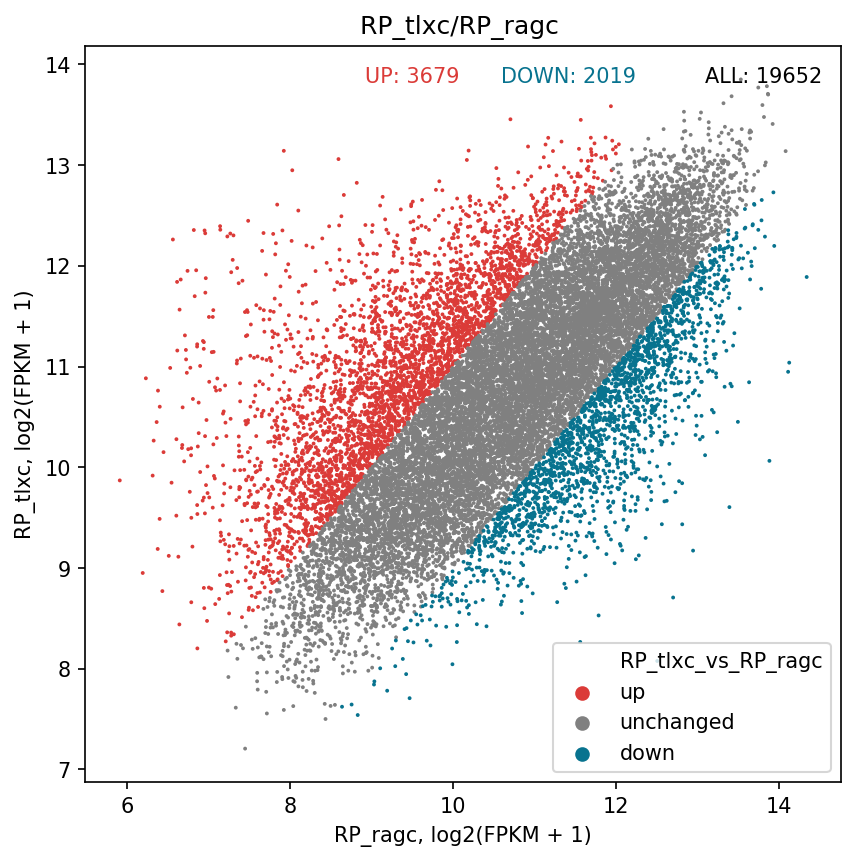

In [13]:
## Scatter of 27ac potential on enhancers

Ap,Bp = 'RP_tlx','RP_rag'
cols = ['name', Ap, Bp]

tlx_rag_27ac_s = tlx_rag_27ac[cols]

tlx_rag_27ac_s = tlx_rag_27ac_s.set_index(keys=tlx_rag_27ac_s.columns[0])

tlx_rag_27ac_s = tlx_rag_27ac_s.apply(pd.to_numeric)

Ac= Ap+'c'
Bc= Bp+'c'

classes=[Ac,Bc]
#df_mean= tlx_rag_27ac_s.groupby(by=classes, axis=1).mean()

df=rn.scatter_n(tlx_rag_27ac_s, Ac, Bc,classes=classes)

In [14]:
## UP regulated by H3K27ac enhancers
tlx_rag_27ac_FC=df[0]


### genes associate with top UP enhancers
tlx_vs_rag_top = list(tlx_rag_27ac_FC.index)
tlx_vs_rag_topGenes = emm.gene_enh(tlx_vs_rag_top,enh2gn)


## UP/DOWN genes regulated by activated in TLX3 enhacers  

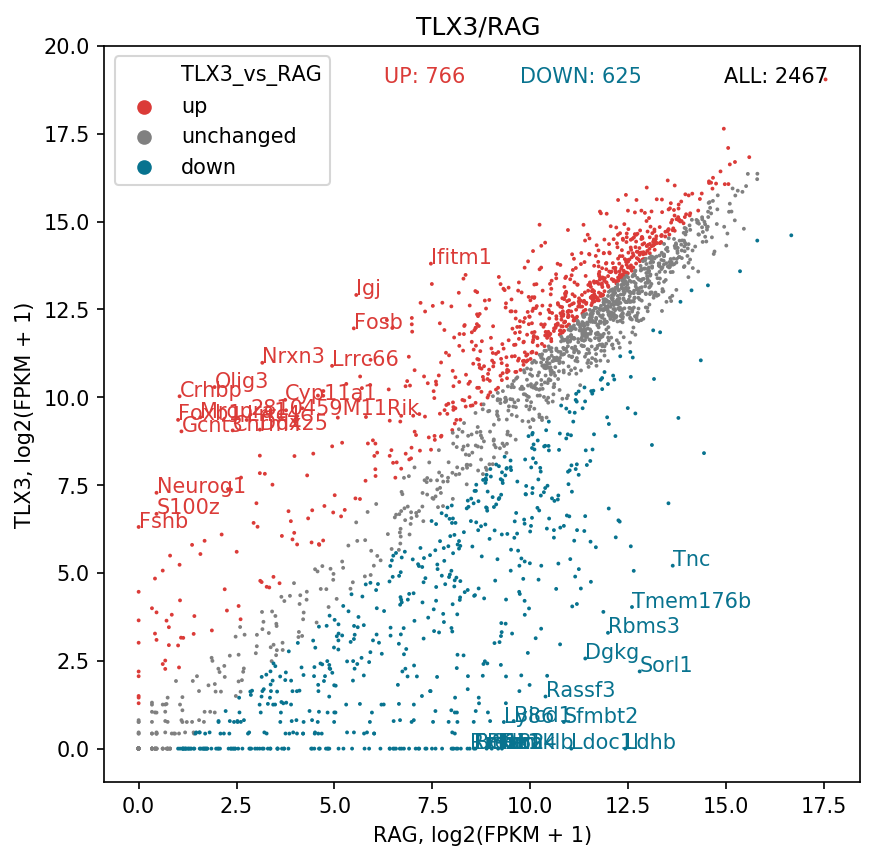

In [15]:
# -- Pheno --
A,B = 'TLX3','RAG'
classes = [A]*3+[B]*3

tmp=rn.scatter_n(expr[expr.index.isin(tlx_vs_rag_topGenes)], A, B,classes=classes, n_top=18)

In [16]:
## enhancers from UP genes
up_genes = list(tmp[0].index)
up_gene_enh =  emm.enh_gene(up_genes,gn2enh)

In [17]:
print('Up regulated enhancers = ',len(tlx_vs_rag_top))
print('Enhancers of up-regulated genes  = ',len(up_gene_enh))

Up regulated enhancers =  3679
Enhancers of up-regulated genes  =  5575


In [18]:
# Up enhancers with up genes
up_enh_up_genes = list(set(tlx_vs_rag_top) & set(up_gene_enh))
print('Up enhancers of up-regulated genes  = ',len(up_enh_up_genes))

Up enhancers of up-regulated genes  =  2183


In [19]:
# Load TLX3 peaks
tlx_pk = pb.BedTool(join(DATADIR,'tracks/TLX3_TLX3_peaks.bed'))
sl = 100
tlx_pk = tlx_pk.slop(b=sl, genome='mm9')

enh_up_up= enh_df[enh_df['name'].isin(up_enh_up_genes)]
enh_up_up_bd = pb.BedTool.from_dataframe(enh_up_up)

enh_up_up_tlx = (enh_up_up_bd + tlx_pk).to_dataframe()

In [20]:
# Finally
# associated genes
enh_up_up_tlx_genes = emm.gene_enh(list(enh_up_up_tlx['name']),enh2gn)

print('Genes for UP regulated (H3K27ac) enhancers with TLX3 peaks  with UP regulated genes = ',len(enh_up_up_tlx_genes))
print('UP regulated (H3K27ac) enhancers with TLX3 peaks  with UP regulated genes = ',len(enh_up_up_tlx))

Genes for UP regulated (H3K27ac) enhancers with TLX3 peaks  with UP regulated genes =  830
UP regulated (H3K27ac) enhancers with TLX3 peaks  with UP regulated genes =  749


## UP regulated final genes

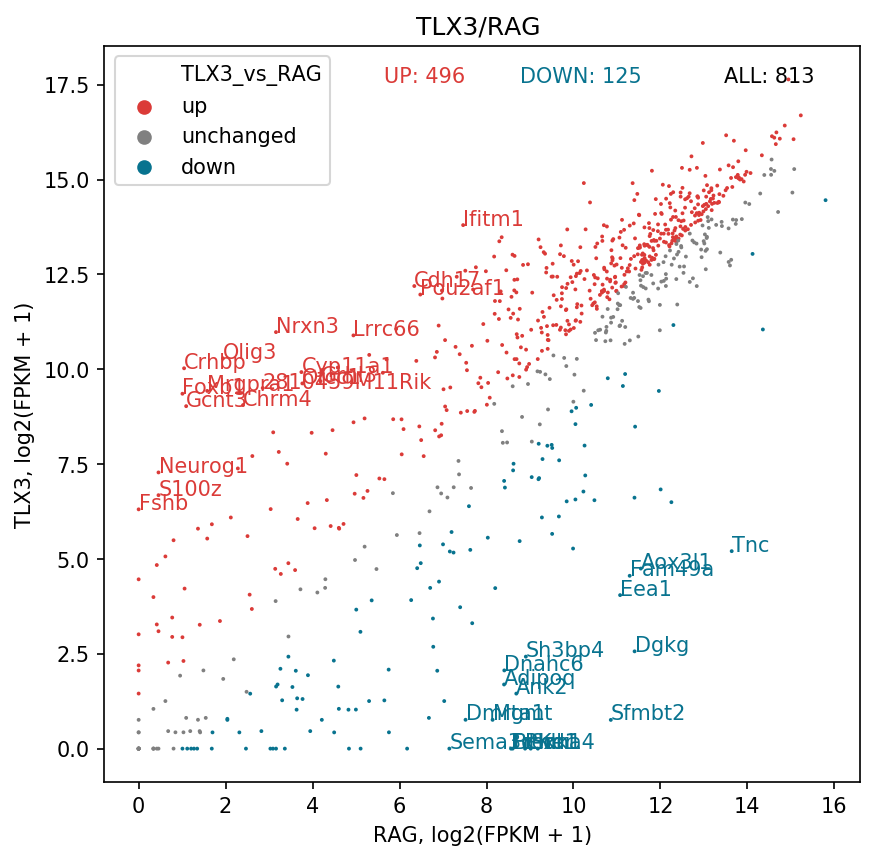

In [21]:
## Expression of last genes

# -- Pheno --
A,B = 'TLX3','RAG'
classes = [A]*3+[B]*3

tmp=rn.scatter_n(expr[expr.index.isin(enh_up_up_tlx_genes)], A, B,classes=classes, n_top=18)

## Enrichment of final 496 genes

In [22]:
fin_up_genes = list(tmp[0].index)

## Enrichment analysis
# List of gene sets 
gss = [ 
       'GO_Biological_Process_2018',
       'GO_Cellular_Component_2018',
       'GO_Molecular_Function_2018',
       'KEGG_2016',
       'Reactome_2016',
       'Cancer_Cell_Line_Encyclopedia',
       'NCI-60_Cancer_Cell_Lines',
       ]

FIN_up_genes = [x.upper() for x in fin_up_genes]

enr = erl.enrich_gs(FIN_up_genes,gss, path_lib='../data/EnrichrLibs')

GO_Biological_Process_2018 2534
GO_Cellular_Component_2018 219
GO_Molecular_Function_2018 523
KEGG_2016 228
Reactome_2016 903
Cancer_Cell_Line_Encyclopedia 825
NCI-60_Cancer_Cell_Lines 93


In [23]:
# For futher analysis it is convinient to filter terms by p-value
enr_a = enr[enr['p-Val']<0.001]


In [24]:
## Cluster: this calculate and add cluster number column
enr_a = erl.cluster(FIN_up_genes,enr_a)

# Make additional calculation on existing columns for visualization
enr_a.loc[:,'ass_genes_percnt'] = 100*enr_a.loc[:,'num_list']/enr_a.loc[:,'num_term']
enr_a.sort_values('cluster', axis=0, inplace = True)


Text(0.5,1,'UP genes regulated by UP enhancers with high Tlx3 peaks')

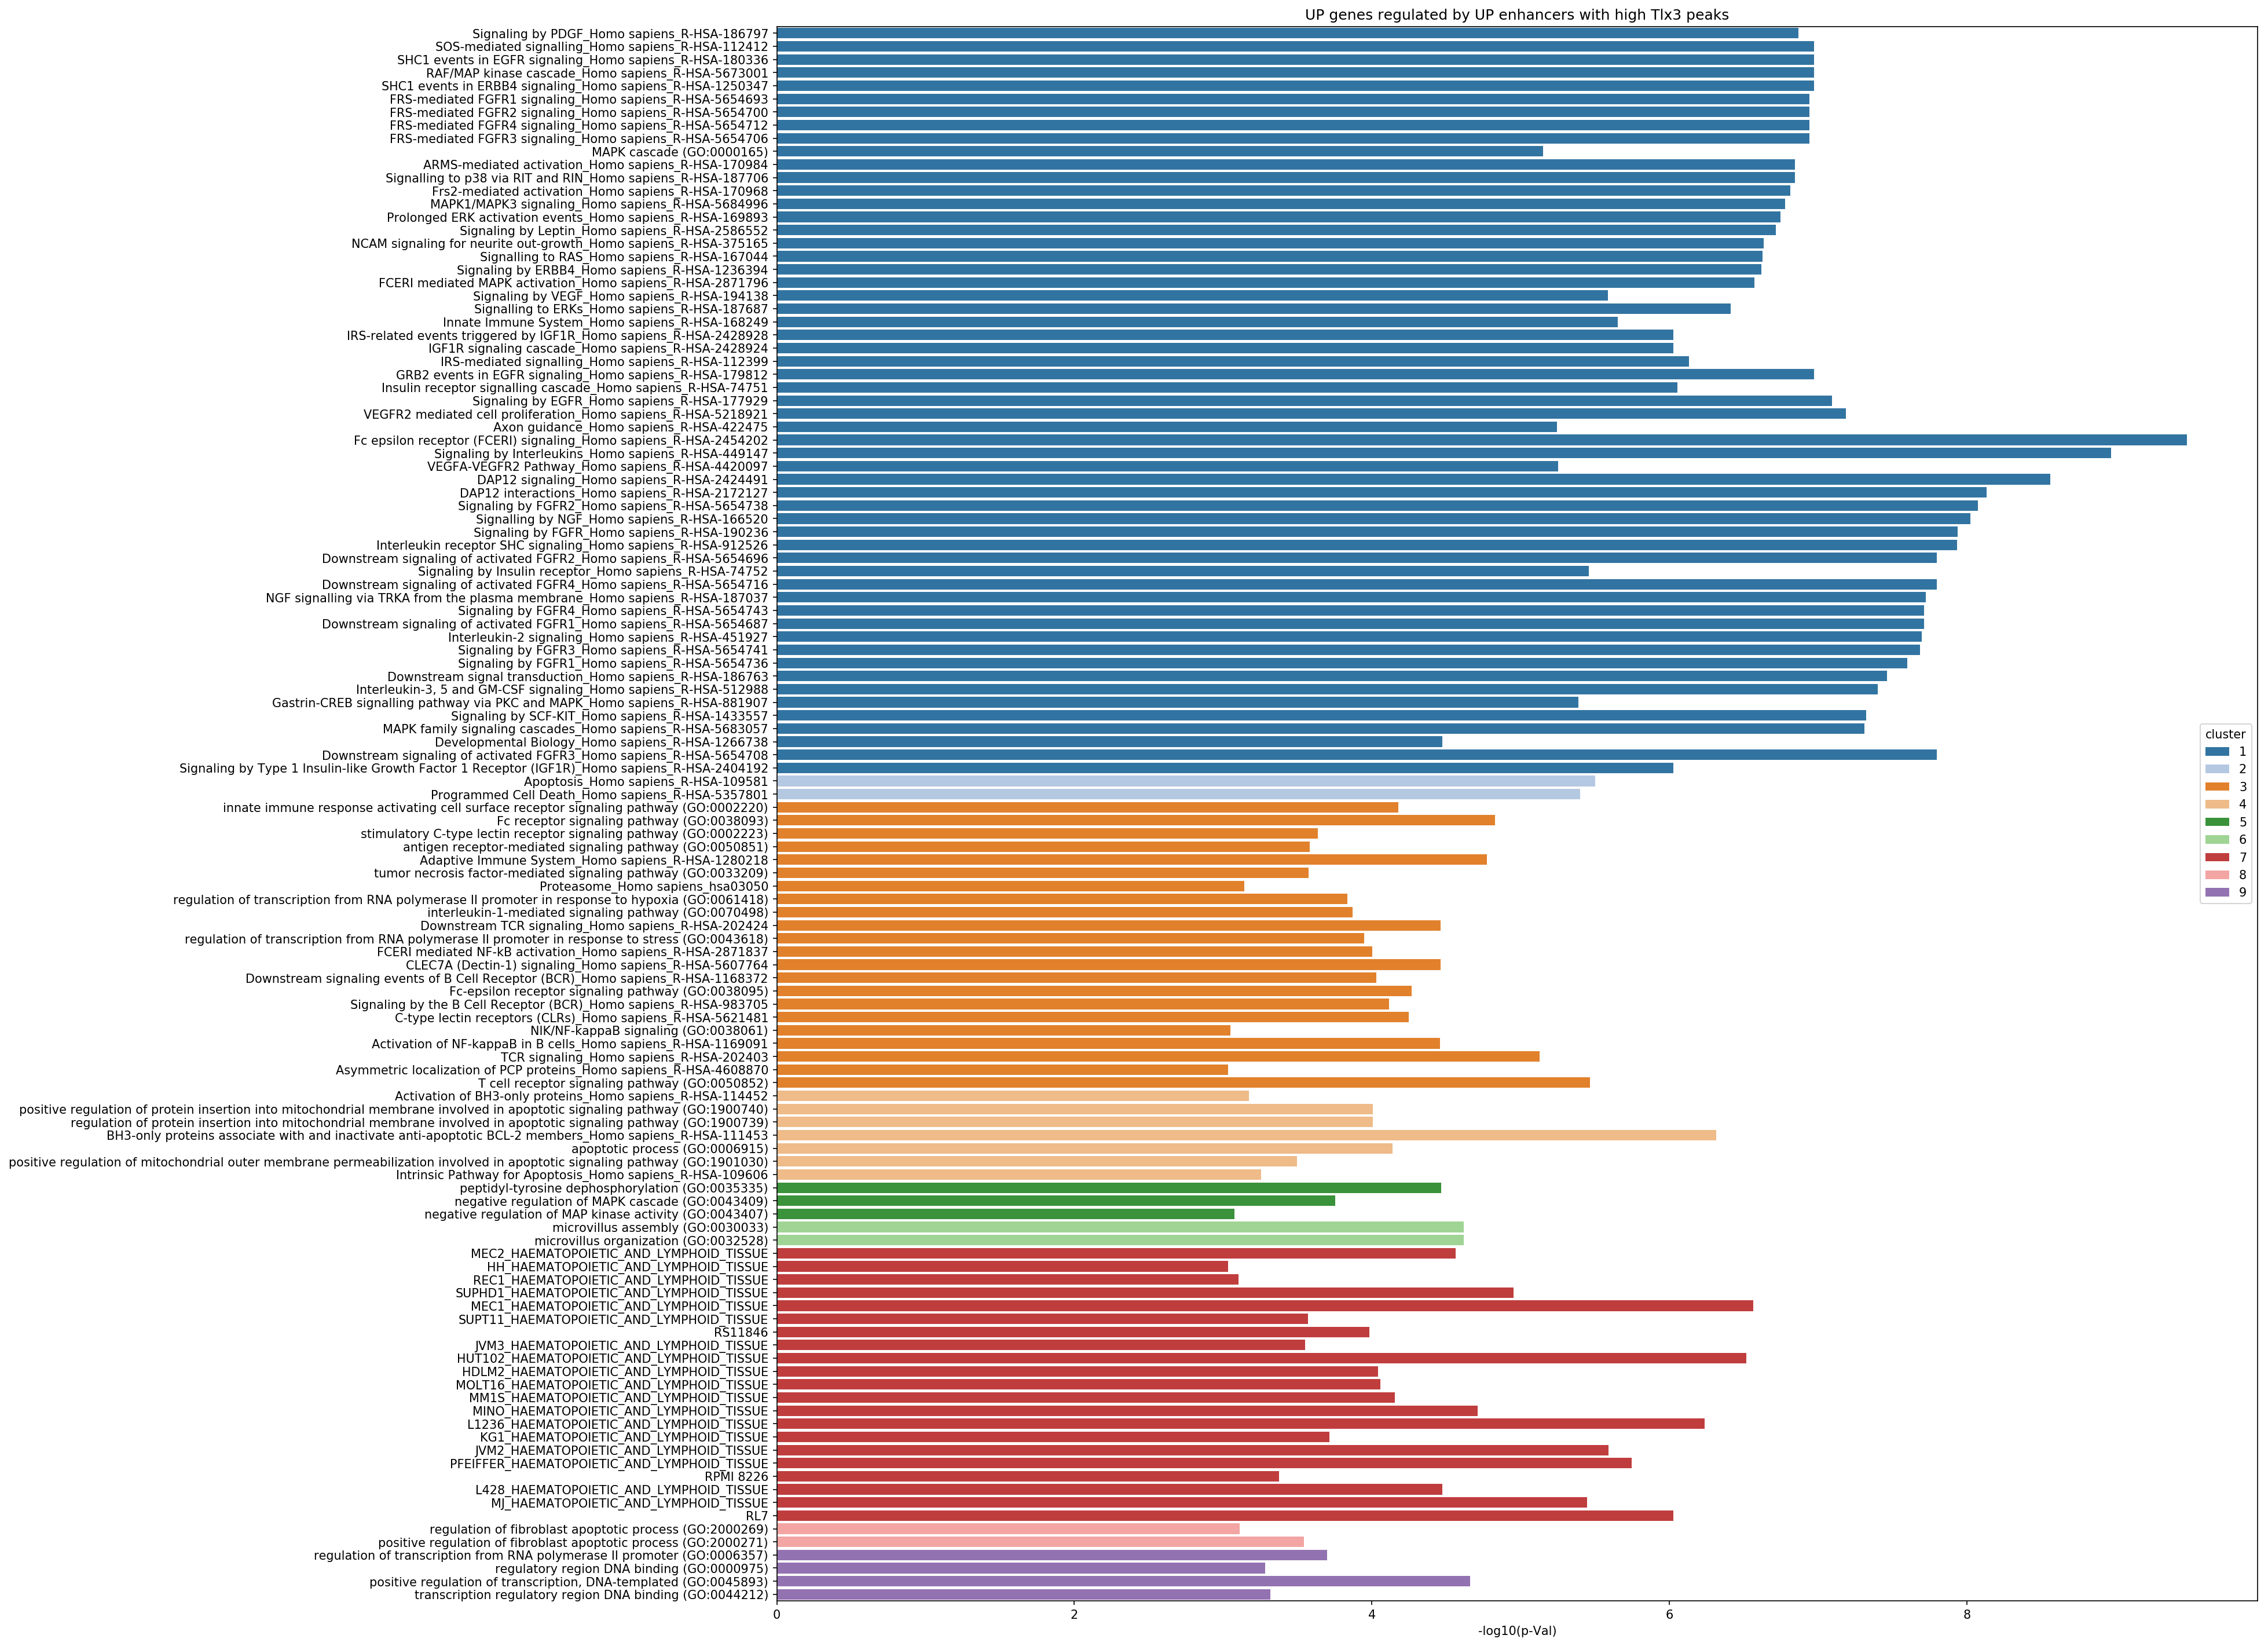

In [30]:
# --- Plot ---
# use consistent discrete palette
cm = 'tab20'

ds = enr_a.head(120)

f, ax = plt.subplots(figsize=(22, 24))
sns.barplot(y=ds.index,
            x='-log10(p-Val)',
            ax = ax, 
            hue ='cluster',
            dodge=False,
            data = ds,
            palette = cm)
ax.set_title('UP genes regulated by UP enhancers with high Tlx3 peaks')



## Calculate independent distance on selected gene sets (terms)

In [31]:
# Calculate independent distance on selected gene sets (terms)
enr_a = erl.cluster_jacc(enr_a)


## Double clustering: close terms in both categories

In [32]:
enr_grp = enr_a.groupby(by=['cluster','cluster_jacc'],axis=0)

# Fucntion takes double cluster and return common genes  

def get_cluster(cl, enr_grp):
    enr_clust = enr_a.loc[enr_grp.groups[cl]]
    gn_clust = set(enr_clust.iloc[0]['genes'])
    for i in range(len(enr_clust)):
        gn_clust = gn_clust & set(enr_clust.iloc[i]['genes'])
    
    return gn_clust

In [33]:
# Print clustes and common genes 


# Terms in cluster
for k in enr_grp.groups.keys():
    print(k)
    for i in list(enr_grp.groups[k]):
        print('\t',i)

#'num_terms :',len(list(enr_grp.groups[k]))


(6, 4)
	 microvillus assembly (GO:0030033)
	 microvillus organization (GO:0032528)
(5, 4)
	 peptidyl-tyrosine dephosphorylation (GO:0035335)
	 negative regulation of MAPK cascade (GO:0043409)
	 negative regulation of MAP kinase activity (GO:0043407)
(4, 4)
	 BH3-only proteins associate with and inactivate anti-apoptotic BCL-2 members_Homo sapiens_R-HSA-111453
	 apoptotic process (GO:0006915)
(11, 4)
	 positive regulation of transcription from RNA polymerase II promoter in response to stress (GO:0036003)
	 positive regulation of endothelial cell proliferation (GO:0001938)
	 cellular response to growth factor stimulus (GO:0071363)
	 regulation of endothelial cell proliferation (GO:0001936)
(10, 4)
	 regulation of interleukin-4 production (GO:0032673)
	 positive regulation of interleukin-4 production (GO:0032753)
(16, 4)
	 positive regulation of protein phosphorylation (GO:0001934)
	 regulation of cellular component organization (GO:0051128)
	 Rap1 signaling pathway_Homo sapiens_hsa04015


In [34]:
# Genes common in clusters 
for k in enr_grp.groups.keys():
    print(k, get_cluster(k, enr_grp))

(6, 4) {'FXYD5', 'RAPGEF2', 'RAP2A', 'RAPGEF6'}
(5, 4) {'DUSP1', 'DUSP10', 'PTPN1', 'PTPRJ', 'DUSP4'}
(4, 4) {'BCL2L11', 'BBC3', 'BCL2', 'BID', 'PMAIP1'}
(11, 4) {'VEGFA'}
(10, 4) {'GATA3', 'CEBPB', 'PRKCQ', 'CD28'}
(16, 4) {'RAP1A'}
(14, 4) {'MALT1', 'MAP4K4', 'BID'}
(13, 4) set()
(19, 4) {'RPS6KA5'}
(18, 4) {'CAMK2D', 'CAMK2B'}
(2, 1) {'PSMA6', 'PSMA1', 'BCL2L11', 'STK24', 'PRKCQ', 'PSMD1', 'PSME4', 'PMAIP1', 'ARHGAP10', 'BCL2', 'BID', 'VIM', 'GZMB', 'GSN', 'PSMB7', 'BBC3'}
(1, 6) {'RASA3', 'PSMA6', 'IL5RA', 'IL2RB', 'PSMA1', 'RASGRP4', 'JAK2', 'PSMD1', 'KIT', 'PSME4', 'GRB2', 'RAPGEF2', 'CALM1', 'CAMK2D', 'PSMB7', 'CAMK2B'}
(9, 4) {'ATF3', 'KLF4', 'GATA3', 'MEF2A', 'SMAD3'}
(4, 2) {'BCL2L11', 'PMAIP1', 'BCL2', 'BID', 'BBC3'}
(17, 4) {'JAK2', 'PIK3CG', 'GRB2'}
(3, 3) {'PSMA6', 'PDCD1LG2', 'PLCG2', 'PSMD1', 'RNF19B', 'INPP5D', 'PHLPP1', 'TPP2', 'RAP1B', 'KIT', 'PRKCQ', 'PSME4', 'IFITM1', 'CALM1', 'CARD11', 'PSMB7', 'PVR', 'SIGLEC5', 'RAP1A', 'LCP2', 'GRB2', 'TRAF6', 'NFKBIA', 'RNF19A'